In [92]:
import torch
from torch import nn

In [93]:
import os
import torch
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import random_split, DataLoader, TensorDataset

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Define the root directory
root_dir = 'data_processed'

# Get the list of directories (labels)
labels = os.listdir(root_dir)

# Initialize an empty list to store the images and labels
data = []
labels_list = []

# Loop over the directories
for label in labels:
    # Get the list of image files in the directory
    image_files = os.listdir(os.path.join(root_dir, label))
    
    # Loop over the image files
    for image_file in image_files:
        # Open the image file
        image = Image.open(os.path.join(root_dir, label, image_file))
        
        # Apply the transformation to the image and add it to the list
        data.append(transform(image))
        
        # Add the label to the list
        labels_list.append(int(label))

# Convert the list of images and labels to PyTorch tensors
data = torch.stack(data)
labels = torch.tensor(labels_list)
labels = labels - 1

# Create a TensorDataset from the data and labels
dataset = TensorDataset(data, labels)

# Define the size of the validation set
val_size = int(len(dataset) * 0.2)  # 20% for validation
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

# Print the sizes of the training and validation sets
print('Training set size:', len(train_dataset))
print('Validation set size:', len(val_dataset))

Training set size: 4105
Validation set size: 1026


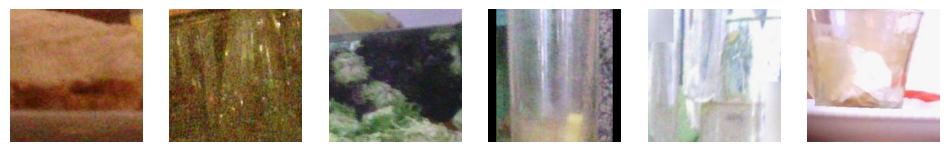

In [94]:
# visualize a sample image
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
inputs, targets = next(iter(train_dataloader))

# Convert the images to numpy arrays
images = inputs.numpy()

# Plot the images
fig, axes = plt.subplots(figsize=(12, 6), ncols=6)
for i in range(6):
    axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[i].axis('off')
plt.show()



In [95]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class ClassificationModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(262144,512),
            nn.ReLU(),
            nn.Linear(512,9)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [96]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [97]:
model = ClassificationModel()
model

ClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in

In [98]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl) 

In [99]:
device = get_default_device()
device

device(type='cuda')

In [100]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)
to_device(model, device)

ClassificationModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in

In [101]:
model = to_device(ClassificationModel(),device)

In [102]:
evaluate(model, val_dataloader)

{'val_loss': 2.1928653717041016, 'val_acc': 0.3394230902194977}

In [103]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, val_dataloader, opt_func)

KeyboardInterrupt: 

In [ ]:
# # Define your model
# model = nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
    
#     nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),
    
#     nn.Flatten(),
# )

# # Pass a batch of input through the model up to the flatten layer
# x = torch.randn(10, 3, 256, 256)
# x = model[:15](x)

# # Print the shape of the output
# print(x.shape)

torch.Size([10, 256, 32, 32])
